In this cycle we:

- Introduced the average ticket feature
- Used 4 clusters according to silhouette and elbow methods
- Used pairplot to find the distribution of features (since we are not in 3 dimensions anymore)
- Used UMAP plot to evaluate how good are the clusters separated, bringing our problem to a lower dimension

# 1 IMPORTS

In [1]:
import pandas as pd
import inflection
import seaborn as sns
import umap.umap_ as umap

import matplotlib.pyplot as plt
from sklearn import cluster as c
from sklearn import metrics as m
from IPython.display import Image
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly import express as px

## 1.1 Definitions 

In [2]:
# Set Seaborn configurations
sns.set_palette('tab10')
sns.set_style('darkgrid')

# Standard font for plots
def std_font(ax1, title, xlabel, ylabel):
    ax1.set_title(title, loc='left', fontdict={'fontsize': 18}, pad=20)
    ax1.set_xlabel(xlabel, fontdict={'fontsize': 12, 'style': 'italic'})
    ax1.set_ylabel(ylabel, fontdict={'fontsize': 12, 'style': 'italic'})
    return None

## 1.2 Loading Data

In [3]:
df_raw = pd.read_csv('data/ecommerce.csv', parse_dates=['InvoiceDate'])
# Renaming columns
cols_snake = list( map( lambda x: inflection.underscore( x ), df_raw.columns ) )
df_raw.columns = cols_snake

# 2 DATA DESCRIPTION

## 2.1 Data Preview

In [4]:
df_raw.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


## 2.2 Data Format and Types

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  float64       
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 2.3 NA Checking and Treatment

In [6]:
df_raw.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 2.3.1 Treating Missing Values

In [7]:
df_raw['description'].fillna(value='NO DESCRIPTION', inplace=True)

df_raw.dropna(inplace=True)

## 2.4 Changing types

In [8]:
df_raw['customer_id'] = df_raw['customer_id'].astype( int )

## 2.5 Discriptive Statistics

In [9]:
df_clean = df_raw.copy()

### 2.5.1 Numerical Attributes

In [10]:
num_att = df_clean.select_dtypes(['int64', 'float64', 'int'])

In [11]:
# getting skew
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).round(2).T
skew.rename(index={0: 'skew'}, inplace=True)

# getting kurtosis
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).round(2).T
kurtosis.rename(index={0: 'kurtosis'}, inplace=True)

# numerical features 
describe = num_att.describe().round(2)
ma = pd.concat([describe, skew, kurtosis], axis=0)
ma

,quantity,unit_price,customer_id
count,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69
std,248.69,69.32,1713.60
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13953.00
50%,5.00,1.95,15152.00
75%,12.00,3.75,16791.00
max,80995.00,38970.00,18287.00
skew,0.18,452.22,0.03
kurtosis,94317.56,246924.54,-1.18


### 2.5.2 Categorical Attributes

In [12]:
cat_att = df_clean.select_dtypes(['object'])

In [13]:
cat_att.apply( lambda x: x.unique().shape[0] )

invoice_no     22190
stock_code      3684
description     3896
country           37
dtype: int64

# 3 DATAFRAME FILTERING

## 3.1 Line Filtering

## 3.2 Column Selection

# 4 QUESTIONS & HYPOTHESIS

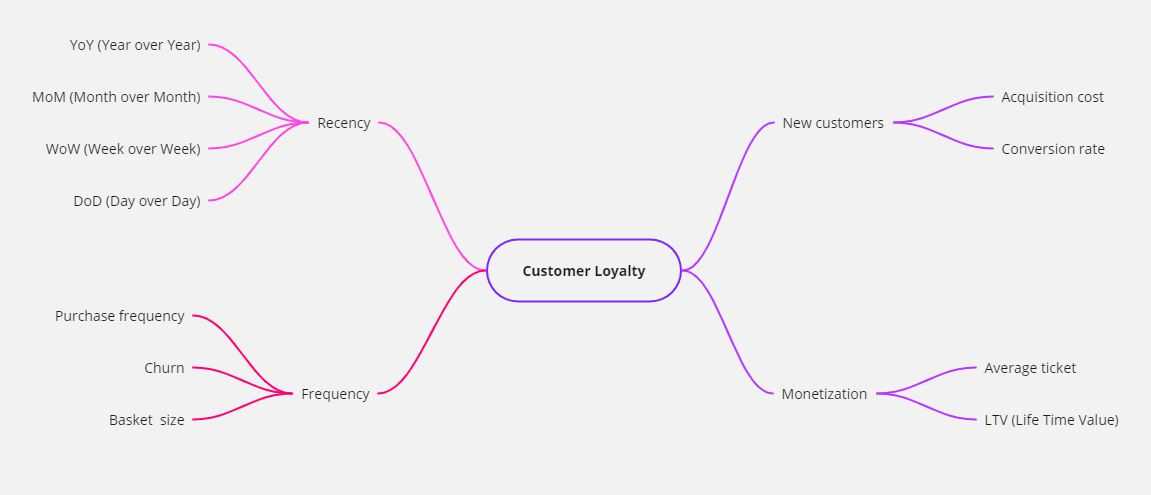

In [14]:
Image( '../images/mindmap.JPG' )

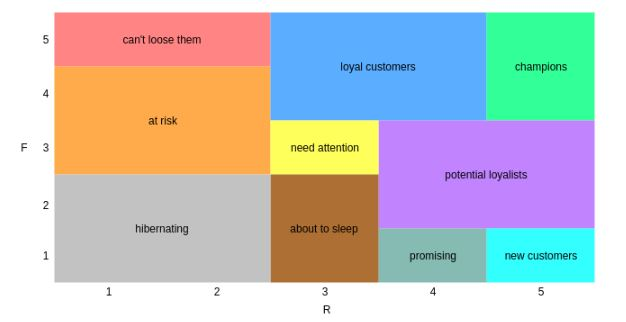

In [15]:
Image( '../images/rfm.JPG' )

Picture - https://medium.com/codex/crm-analytics-rfm-analysis-90aa2ae55fbc

# 5 FEATURE ENGINEERING

In [16]:
# ====================
# CREATING RFM TABLE
# ====================

# initiating df_rfm table with customers IDs
df_rfm = df_clean.drop( ['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )

# monetary
df_clean['gross_revenue'] = df_clean['quantity'] * df_clean['unit_price']
df_monetary = df_clean[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_rfm = pd.merge( df_rfm, df_monetary, on='customer_id', how='left' )

# recency
df_recency = df_clean[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df_clean['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_rfm = pd.merge( df_rfm, df_recency, on='customer_id', how='left' )

# frequency
df_freq = df_clean[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_rfm = pd.merge( df_rfm, df_freq, on='customer_id', how='left' )

# average ticket
df_avg_ticket = df_clean[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_rfm = pd.merge( df_rfm, df_avg_ticket, on='customer_id', how='left')



In [17]:
df_rfm.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# 6 EXPLORATORY DATA ANALYSIS

## 6.1 Univariate Analysis

### 6.1.1 Response Variable

### 6.1.2 Numerical Variable

### 6.1.3 Categorical Variable

## 6.2 Bivariate Analysis

## 6.3 Multivariate Analysis


### 6.3.1 Numerical Attributes

### 6.3.2 Categorical Attributes

# 7 DATA PREPARATION

## 7.2 Normalization

## 7.3 Rescaling

## 7.4 Transformation

### 7.4.1 Encoding

# 8 FEATURE SELECTION

## 8.1 Split dataframe into training and validation dataset

## 8.3 Selected Features

# 9 MACHINE LEARNING MODELLING

In [18]:
clusters = [2, 3, 4, 5, 6, 7]
X = df_rfm.drop( columns=['customer_id'] )

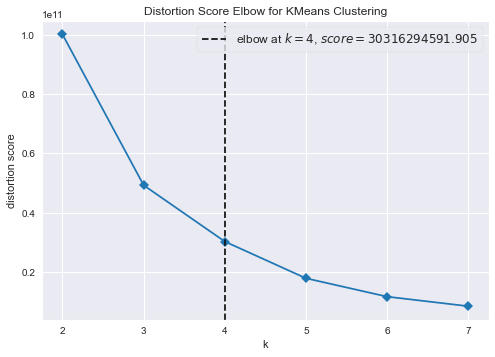

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show()

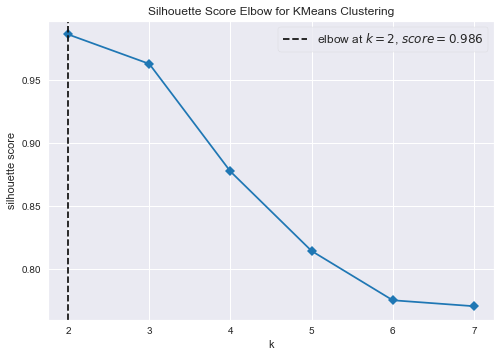

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [20]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

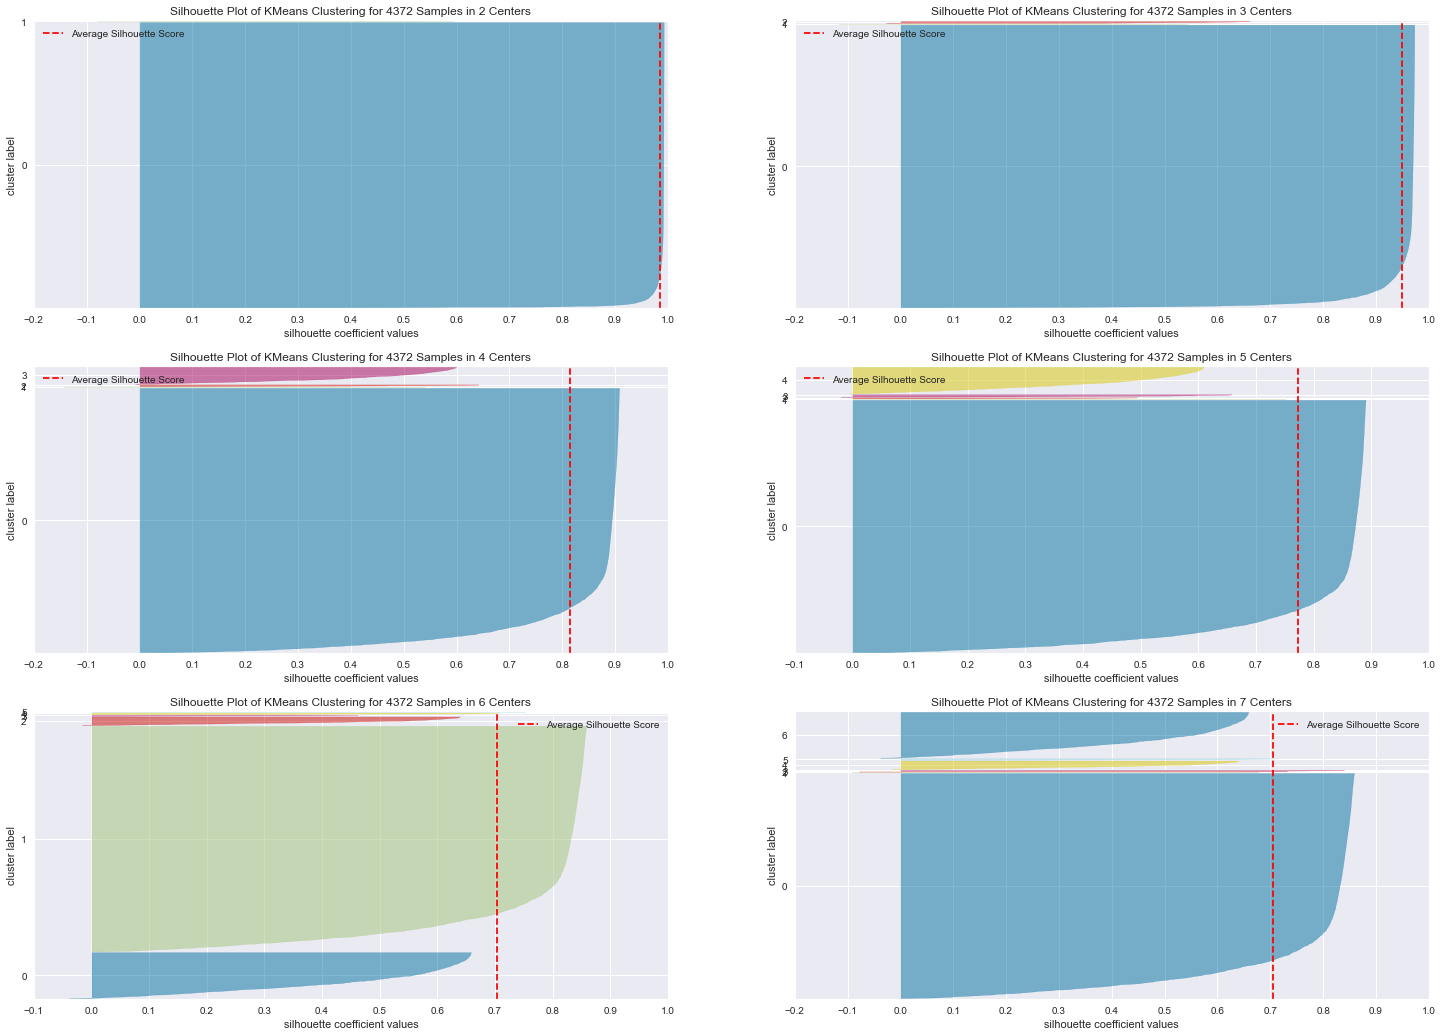

In [21]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

## KMEANS 4 Clusters

In [22]:
kmeans = c.KMeans(init='random', n_clusters=4, n_init=10, max_iter=300, random_state=42) 
kmeans.fit(X)
labels = kmeans.labels_

In [23]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 40056506734.60249
SS value: 0.8139972028952444


In [24]:
df_rfm['cluster'] = labels
df_rfm.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


### 9.1.1 Silhouette Visualization

In [34]:
df_viz = df_rfm.drop(columns='customer_id')

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


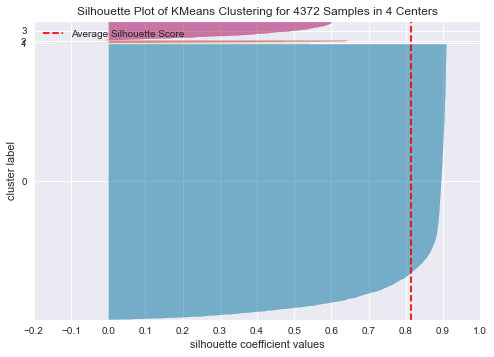

In [25]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 9.1.1 Pairplot Visualization

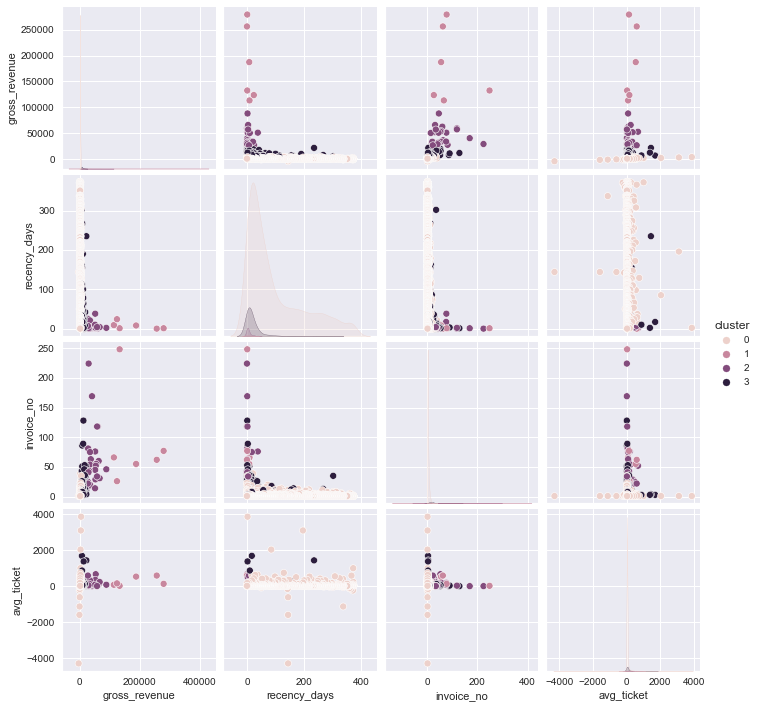

In [35]:
sns.pairplot(df_viz, hue='cluster')

### 9.1.1 UMAP 

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

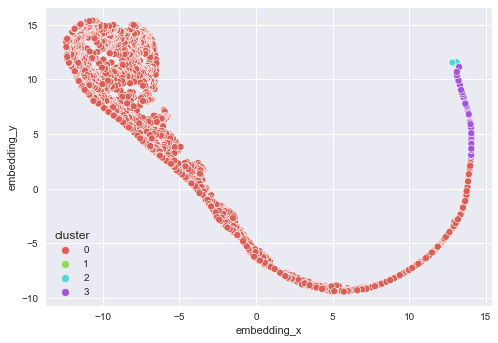

In [36]:
reducer = umap.UMAP( n_neighbors=80, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

### 9.1.2 Clusters Info

In [37]:
# Number of customer
df_cluster = df_rfm[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df_rfm[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df_rfm[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df_rfm[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# # Avg Ticket
# df_ticket = df_rfm[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
# df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no
0,0,4071,93.115279,946.696250,96.969295,3.641120
1,1,6,0.137237,182181.981667,7.166667,89.000000
2,2,28,0.640439,42614.387143,6.178571,57.821429
3,3,267,6.107045,8089.028652,20.280899,19.528090


# 10 CROSS-VALIDATION

# 11 HYPERPARAMETER FINE TUNNING

## 11.1 Random Search

## 11.2 Final Model

# 12 BUSINESS PERFORMANCE

Cluster 01: 
- Number of customers: 6 (0.14% of customers )
- Average Recency: 7 days
- Average invoice_no: 89 
- Average Gross Revenue: U\$182,182.00

Cluster 02:
- Number of customers: 28 (0.64% of customers )
- Average Recency: 6 days
- Average invoice_no: 58 
- Average Gross Revenue: U\$42,614.38 

Cluster 03:
- NNumber of customers: 4.071 (93% of customers )
- Average Recency: 97 days
- Average invoice_no: 3.6 
- Average Gross Revenue: U\$946.69 

Cluster 04:
- NNumber of customers: 267 (6.1% of customers )
- Average Recency: 20.3 days
- Average invoice_no: 19.5 
- Average Gross Revenue: U\$8,092.02 

## 12.1 Scenario: Cost to Reach 87% of Interested Customers

## 12.2 Scenario: Making only 20,000 calls

# 13 NEXT STEPS